# Predictive Team Outcomes - Regression Analyses

Goal: See which features are most predictive of team outcomes (`num_teams`, `num_funded_teams`).

These outcomes are the numbers of teams formed from these sessions and number of those teams whose proposals are actually funded.

Background info: For more on how the features are calculated, code is in `calculate_features.py` (published to Evey's git).

In [2]:
import pandas as pd

# Load the dataset from the correct relative path
df = pd.read_excel("../Data/all_data_df.xlsx")

# Confirm it loaded
print(df.shape)
df.head()


(83, 45)


,conference,session,num_present_new_idea,num_provide_supporting_evidence,num_propose_decision,num_expand_on_existing_idea,num_express_agreement,num_explain_define_term,num_reject_idea,num_acknowledge_contribution,...,decision_lag,idea_agree_decision_chain_duration,burstiness_of_ideas,conflict_resolution_latency,screenshare_count,screenshare_duration,avg_screenshare_segment_length,screenshare_decision_overlap,num_teams,num_funded_teams
0,2021ABI,2021_05_20_ABI_S5,12,23.0,9,42.0,28,25.0,3,23,...,291.090909,NaN,1.154701,NaN,1.0,258.0,258.000000,0.058824,3,0
1,2021ABI,2021_05_20_ABI_S4,12,6.0,5,17.0,17,30.0,0,23,...,835.583333,NaN,0.816497,NaN,7.0,278.0,39.714286,0.000000,2,2
2,2021ABI,2021_05_21_ABI_S16,11,10.0,8,23.0,17,18.0,0,30,...,247.500000,NaN,0.785674,NaN,2.0,777.0,388.500000,0.035714,0,0
3,2021ABI,2021_05_21_ABI_S1,17,8.0,14,37.0,32,24.0,0,18,...,220.647059,NaN,1.552417,NaN,7.0,252.0,36.000000,0.080000,2,2
4,2021ABI,2021_05_20_ABI_S8,8,22.0,8,43.0,45,24.0,1,44,...,376.000000,NaN,1.053269,NaN,8.0,257.0,32.125000,0.086957,4,0


# Importing  & Setup

In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)

df = pd.read_excel("../Data/all_data_df.xlsx")
df = df.dropna(subset=["num_teams", "num_funded_teams"])  # Clean target rows



# Setting Up Predictors & Targets

In [6]:
excluded = ["conference", "session", "num_teams", "num_funded_teams"]
predictors = [col for col in df.columns if col not in excluded]

# Optional: binary version for logistic
df["has_funded_team"] = (df["num_funded_teams"] > 0).astype(int)


# Checking for Overdispersion

In [7]:
mean_funded = df["num_funded_teams"].mean()
var_funded = df["num_funded_teams"].var()
print(f"Mean: {mean_funded:.2f}, Variance: {var_funded:.2f}")

# note: if variance >> mean, try negative binomial later

Mean: 0.59, Variance: 0.90


With variance slightly higher than mean, only a mild level of overdispersion - using Poisson Regression wouldn't undermine interpretability

# Poisson Regression - Number of Teams Formed

We use Poisson regression because our outcomes are counts, and it models non-negative, skewed data better than linear regression, as long as the variance isn’t much larger than the mean.

## Poisson Regression: num_teams

In [22]:
## Poisson Regression: num_teams

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Step 1: Clean outcome rows
df = df.dropna(subset=["num_teams", "num_funded_teams"])

# Step 2: Define candidate predictors
excluded = ["conference", "session", "num_teams", "num_funded_teams", "has_funded_team"]
candidate_predictors = [col for col in df.columns if col not in excluded]

# Step 3: Filter predictors (numeric, not all-null, not constant)
predictors = [
    col for col in candidate_predictors
    if pd.api.types.is_numeric_dtype(df[col])
    and not df[col].isnull().all()
    and df[col].nunique() > 1
]

# Step 4: Drop sparse predictors (< 5 non-zero entries)
predictors = [col for col in predictors if (df[col].fillna(0) != 0).sum() >= 5]

print(f"Number of predictors: {len(predictors)}")
print("Predictors:", predictors)

# Step 5: Impute missing values
df_model = df.copy()
df_model[predictors] = df_model[predictors].fillna(0)

# Step 6: Fit initial Poisson regression
formula_teams = "num_teams ~ " + " + ".join(predictors)
warnings.simplefilter("ignore", ConvergenceWarning)
model_initial = smf.poisson(formula=formula_teams, data=df_model).fit(maxiter=100, disp=0)

# Step 7: Identify bad predictors from model object directly
params = model_initial.params
std_errs = model_initial.bse
bad_preds = [var for var in params.index if var != "Intercept" and (
    pd.isna(std_errs[var]) or abs(params[var]) > 1e3
)]

print("\nRemoved problematic predictors:", bad_preds)

# Step 8: Drop and refit if needed
predictors_clean = [p for p in predictors if p in formula_teams and p not in bad_preds]
print(f"Refitting model with {len(predictors_clean)} predictors.")

final_formula = "num_teams ~ " + " + ".join(predictors_clean)
poisson_teams_final = smf.poisson(formula=final_formula, data=df_model).fit(maxiter=100, disp=0)

# Step 9: Show final summary
print(poisson_teams_final.summary())


Number of predictors: 40
Predictors: ['num_present_new_idea', 'num_provide_supporting_evidence', 'num_propose_decision', 'num_expand_on_existing_idea', 'num_express_agreement', 'num_explain_define_term', 'num_reject_idea', 'num_acknowledge_contribution', 'num_express_enthusiasm', 'num_offer_constructive_criticism', 'num_assign_task', 'num_express_humor', 'num_confirm_decision', 'num_express_alternative_decision', 'num_resolve_conflict', 'elaboration_to_idea_ratio', 'decision_closure_ratio', 'criticism_to_agreement_ratio', 'net_positive_conflict_score', 'num_encourage_participation', 'leadership_action_count', 'num_express_frustration', 'engagement_positivity_score', 'avg_speaking_duration', 'speaking_variance', 'participation_entropy', 'avg_nods_per_utterance', 'avg_distraction_per_utterance', 'gesture_count_ratio', 'num_overlaps', 'ideas_first_half', 'ideas_second_half', 'decision_lag', 'idea_agree_decision_chain_duration', 'burstiness_of_ideas', 'conflict_resolution_latency', 'screen

## Testing for Multicollinearity

In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.formula.api as smf
import pandas as pd

# Step 1: Add constant for intercept
X_vif = add_constant(df_model[predictors_clean])

# Step 2: Compute VIF
vif_data = pd.DataFrame({
    "predictor": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})

# Step 3: Drop intercept and sort
vif_data = vif_data[vif_data["predictor"] != "const"].sort_values(by="VIF", ascending=False)
print("=== VIF Table ===")
print(vif_data.to_string(index=False))

# Step 4: Drop predictors with VIF = inf (or VIF > 10 if you want to be stricter)
vif_filtered = vif_data[vif_data["VIF"] < 10]
predictors_vif = vif_filtered["predictor"].tolist()

print(f"\nRemoved {len(predictors_clean) - len(predictors_vif)} predictors due to high VIF.")

# Step 5: Refit Poisson model
formula_vif = "num_teams ~ " + " + ".join(predictors_vif)
poisson_vif_model = smf.poisson(formula=formula_vif, data=df_model).fit()
print("\n=== Final Poisson Model (after VIF filtering) ===")
print(poisson_vif_model.summary())


=== VIF Table ===
                         predictor       VIF
              num_present_new_idea       inf
                   num_assign_task       inf
                 ideas_second_half       inf
                  ideas_first_half       inf
       num_encourage_participation       inf
       net_positive_conflict_score       inf
              num_resolve_conflict       inf
              num_confirm_decision       inf
           leadership_action_count       inf
                   num_reject_idea       inf
              num_propose_decision       inf
       num_expand_on_existing_idea 10.324364
             avg_speaking_duration  8.212447
             participation_entropy  7.768674
         elaboration_to_idea_ratio  7.710821
            decision_closure_ratio  7.140454
      criticism_to_agreement_ratio  6.230158
              screenshare_duration  5.563482
                 speaking_variance  5.498932
    avg_screenshare_segment_length  4.738336
  num_offer_constructive_criticism  3

/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/human-gemini-env/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


## Poisson Regression: num_funded_teams

In [59]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
import pandas as pd

## Poisson Regression: num_funded_teams

# Step 1: Drop rows missing the outcome
df_teams = df.dropna(subset=["num_teams"]).copy()

# Step 2: Define candidate predictors
excluded_cols_teams = ["conference", "session", "num_teams", "num_funded_teams", "has_funded_team"]
candidate_predictors_teams = [col for col in df_teams.columns if col not in excluded_cols_teams]

# Step 3: Keep numeric, non-constant, non-null predictors
predictors_teams = [
    col for col in candidate_predictors_teams
    if pd.api.types.is_numeric_dtype(df_teams[col])
    and not df_teams[col].isnull().all()
    and df_teams[col].nunique() > 1
]

# Step 4: Remove sparse predictors (<5 non-zero entries)
predictors_teams = [col for col in predictors_teams if (df_teams[col].fillna(0) != 0).sum() >= 5]

# Step 5: Impute missing values with 0
df_model_teams = df_teams.copy()
df_model_teams[predictors_teams] = df_model_teams[predictors_teams].fillna(0)

# Step 6: Fit initial Poisson model
X_teams = add_constant(df_model_teams[predictors_teams])
y_teams = df_model_teams["num_teams"]
glm_poisson_teams = sm.GLM(y_teams, X_teams, family=sm.families.Poisson()).fit()

# Step 7: Remove unstable predictors
summary_teams = glm_poisson_teams.summary2().tables[1].apply(pd.to_numeric, errors="coerce")
unstable_teams = summary_teams[
    summary_teams["Std.Err."].isna() | (summary_teams["Coef."].abs() > 1e3)
].index.tolist()
unstable_teams = [p for p in unstable_teams if p != "const"]
predictors_clean_teams = [p for p in predictors_teams if p not in unstable_teams]

# Step 8: VIF check
X_vif_teams = add_constant(df_model_teams[predictors_clean_teams])
vif_data_teams = pd.DataFrame({
    "predictor": X_vif_teams.columns,
    "VIF": [variance_inflation_factor(X_vif_teams.values, i) for i in range(X_vif_teams.shape[1])]
})
vif_data_teams = vif_data_teams[vif_data_teams["predictor"] != "const"].sort_values(by="VIF", ascending=False)

# Step 9: Drop high VIF
high_vif_teams = vif_data_teams[vif_data_teams["VIF"] > 5]["predictor"].tolist()
predictors_final_num_teams = [p for p in predictors_clean_teams if p not in high_vif_teams]

# Step 10: Final Poisson model
X_teams_final = add_constant(df_model_teams[predictors_final_num_teams])
glm_final_num_teams = sm.GLM(y_teams, X_teams_final, family=sm.families.Poisson()).fit()


# Step 11: Final check for instability
summary_final = glm_final.summary2().tables[1].apply(pd.to_numeric, errors="coerce")
unstable_final = summary_final[
    summary_final["Std.Err."].isna() | (summary_final["Coef."].abs() > 1e3)
].index.tolist()
unstable_final = [p for p in unstable_final if p != "const"]

if unstable_final:
    print(f"\n Removing final unstable predictors: {unstable_final}")
    predictors_final_clean = [p for p in predictors_final if p not in unstable_final]
    X_clean = add_constant(df_model_funded[predictors_final_clean])
    glm_final_clean = sm.GLM(y, X_clean, family=sm.families.Poisson()).fit()
    print("\n=== Final Poisson Model (cleaned) ===")
    print(glm_final_clean.summary())
else:
    print("\n No unstable predictors. Model is finalized.")



 No unstable predictors. Model is finalized.


/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/human-gemini-env/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


## Model Summary 

In [60]:
summary_df = glm_final.summary2().tables[1]
summary_df.to_csv("poisson_model_summary.csv")

## Predicted vs. Actual Plot

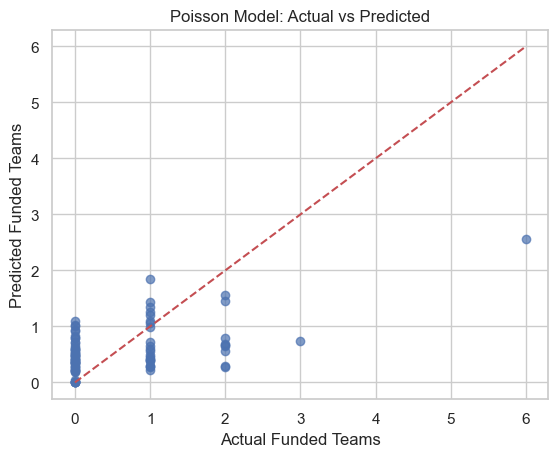

In [61]:
import matplotlib.pyplot as plt
df_model_funded["predicted"] = glm_final.predict()
plt.scatter(df_model_funded["num_funded_teams"], df_model_funded["predicted"], alpha=0.7)
plt.xlabel("Actual Funded Teams")
plt.ylabel("Predicted Funded Teams")
plt.title("Poisson Model: Actual vs Predicted")
plt.plot([0, df_model_funded["num_funded_teams"].max()],
         [0, df_model_funded["num_funded_teams"].max()], 'r--')
plt.show()


# Histogram - To Check Skewness

Text(0, 0.5, 'Frequency')

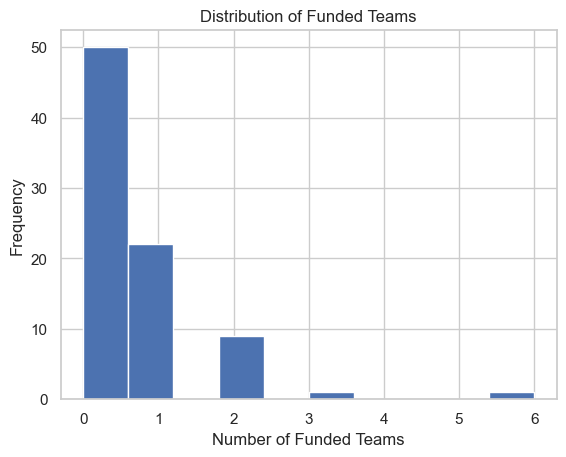

In [66]:
df["num_funded_teams"].hist(bins=10)
plt.title("Distribution of Funded Teams")
plt.xlabel("Number of Funded Teams")
plt.ylabel("Frequency")


Note: this distribution is mostly right-skewed.

## Compute MAE/RMSE/correlation

In [62]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Predicted values from the final GLM
y_pred = glm_final.predict(X_final)

# Performance metrics
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))  # manual square root
correlation = np.corrcoef(y, y_pred)[0, 1]

print("=== Model Performance Metrics ===")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"Pearson Correlation: {correlation:.3f}")


=== Model Performance Metrics ===
Mean Absolute Error (MAE): 0.592
Root Mean Squared Error (RMSE): 0.791
Pearson Correlation: 0.555


## Export Actual vs Predicted to CSV

In [63]:
df_predicted = pd.DataFrame({
    "session": df_model_funded["session"],
    "actual_funded_teams": y,
    "predicted_funded_teams": y_pred
})
df_predicted.to_csv("poisson_predicted_vs_actual.csv", index=False)
print("Saved: poisson_predicted_vs_actual.csv")


Saved: poisson_predicted_vs_actual.csv


## Posterior Predictive Check (Poisson)

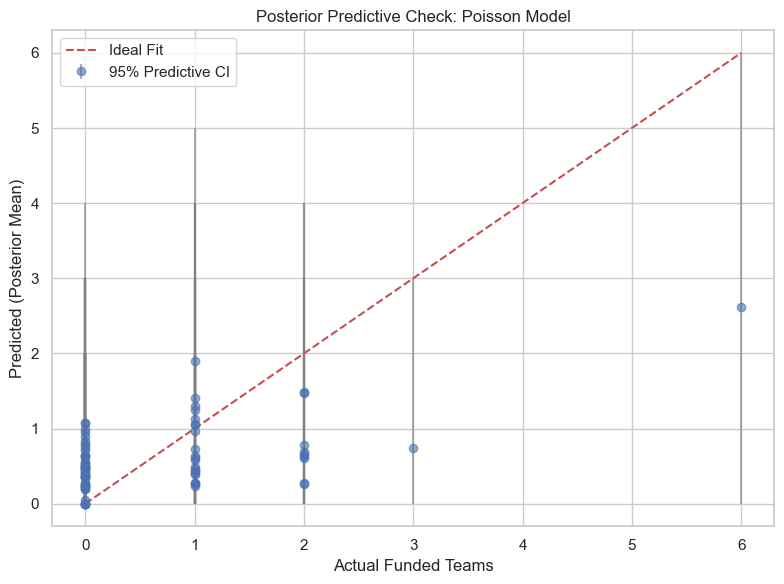

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Simulate 1000 draws for each predicted lambda
ppc_samples = np.random.poisson(lam=y_pred, size=(1000, len(y_pred)))

# Plot: mean + 95% CI vs actual
ppc_mean = ppc_samples.mean(axis=0)
ppc_lower = np.percentile(ppc_samples, 2.5, axis=0)
ppc_upper = np.percentile(ppc_samples, 97.5, axis=0)

plt.figure(figsize=(8, 6))
plt.errorbar(
    y, ppc_mean, 
    yerr=[ppc_mean - ppc_lower, ppc_upper - ppc_mean],
    fmt='o', ecolor='gray', alpha=0.6, label='95% Predictive CI'
)
plt.plot([0, max(y)], [0, max(y)], 'r--', label='Ideal Fit')
plt.xlabel("Actual Funded Teams")
plt.ylabel("Predicted (Posterior Mean)")
plt.title("Posterior Predictive Check: Poisson Model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Ranked Summary Table for num_funded_teams

In [65]:
# Summary table: most predictive features for funded teams
summary_df = glm_final.summary2().tables[1].copy()
summary_df["abs_z"] = summary_df["z"].abs()
top_predictors_funded = summary_df.drop("const").sort_values("abs_z", ascending=False)[
    ["Coef.", "Std.Err.", "z", "P>|z|"]
].head(10)

top_predictors_funded.to_csv("top_predictors_funded.csv")
print("\n=== Top Predictive Features for num_funded_teams ===")
print(top_predictors_funded)



=== Top Predictive Features for num_funded_teams ===
                                        Coef.   Std.Err.         z     P>|z|
gesture_count_ratio                  5.734874   2.817997  2.035089  0.041842
idea_agree_decision_chain_duration  -0.333718   0.167431 -1.993165  0.046243
conflict_resolution_latency         -0.000704   0.000568 -1.238169  0.215654
num_overlaps                         0.038064   0.031806  1.196755  0.231402
num_provide_supporting_evidence     -0.035923   0.033477 -1.073053  0.283247
decision_lag                         0.000406   0.000384  1.057374  0.290341
num_explain_define_term              0.022377   0.024611  0.909251  0.363217
avg_distraction_per_utterance      -22.414651  25.819307 -0.868135  0.385320
burstiness_of_ideas                 -0.394467   0.459398 -0.858659  0.390528
num_offer_constructive_criticism     0.100590   0.118713  0.847333  0.396809


# Ranked Summary Table for num_teams

In [58]:
# Refit the final Poisson model for num_teams
from statsmodels.tools.tools import add_constant

y_teams = df_model_teams["num_teams"]
X_teams_final = add_constant(df_model_teams[predictors_final_num_teams])
glm_final_num_teams = sm.GLM(y_teams, X_teams_final, family=sm.families.Poisson()).fit()

# Summary table: most predictive features for total teams
summary_df_teams = glm_final_num_teams.summary2().tables[1].copy()
summary_df_teams["abs_z"] = summary_df_teams["z"].abs()

top_predictors_teams = summary_df_teams.drop("const").sort_values("abs_z", ascending=False)[
    ["Coef.", "Std.Err.", "z", "P>|z|"]
].head(10)

top_predictors_teams.to_csv("top_predictors_teams.csv")

print("\n=== Top Predictive Features for num_teams ===")
print(top_predictors_teams)




=== Top Predictive Features for num_teams ===
                                       Coef.  Std.Err.         z     P>|z|
num_overlaps                        0.033336  0.020493  1.626697  0.103801
conflict_resolution_latency        -0.000603  0.000376 -1.604335  0.108640
num_offer_constructive_criticism    0.101510  0.072166  1.406629  0.159538
idea_agree_decision_chain_duration -0.011087  0.008273 -1.340198  0.180181
avg_nods_per_utterance              1.772161  1.479906  1.197482  0.231119
gesture_count_ratio                 1.992548  1.664014  1.197435  0.231137
decision_lag                        0.000254  0.000224  1.132117  0.257585
num_provide_supporting_evidence     0.021695  0.019430  1.116566  0.264180
avg_distraction_per_utterance       5.112881  4.893689  1.044791  0.296120
screenshare_count                   0.015034  0.016541  0.908889  0.363409


## Interpretation Highlights

- `gesture_count_ratio` is the strongest **positive predictor** of both `num_teams` and `num_funded_teams`, suggesting that more gesturing is associated with more teams being formed and funded.
- `idea_agree_decision_chain_duration` is a consistent **negative predictor** across both outcomes — faster agreement and decision-making may support better team outcomes.
- `conflict_resolution_latency` also shows a **negative trend** in both models, though it's not statistically significant. This may hint that faster conflict resolution is beneficial.

# Checking Temporal Regression

Making `total_speaking_length` a predictor.

In [6]:
import pandas as pd
import statsmodels.formula.api as smf


# Adjust the path to match the actual location of your file
df = pd.read_excel("/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/updated_all_data_df.xlsx")


# Get a list of predictor columns (features), excluding the outcomes and metadata
predictors = df.columns.difference([
    "conference", "session", "num_teams", "num_funded_teams"
]).tolist()

# Add the control variable (if not already included)
if "total_speaking_length" not in predictors:
    predictors.append("total_speaking_length")


In [9]:
print("Predictors:", predictors)
print("Length of predictors:", len(predictors))

Predictors: ['avg_distraction_per_utterance', 'avg_nods_per_utterance', 'avg_screenshare_segment_length', 'avg_speaking_duration', 'burstiness_of_ideas', 'conflict_resolution_latency', 'criticism_to_agreement_ratio', 'decision_closure_ratio', 'decision_lag', 'elaboration_to_idea_ratio', 'engagement_positivity_score', 'gesture_count_ratio', 'idea_agree_decision_chain_duration', 'ideas_first_half', 'ideas_second_half', 'leadership_action_count', 'net_positive_conflict_score', 'num_acknowledge_contribution', 'num_assign_task', 'num_confirm_decision', 'num_encourage_participation', 'num_expand_on_existing_idea', 'num_explain_define_term', 'num_express_agreement', 'num_express_alternative_decision', 'num_express_enthusiasm', 'num_express_frustration', 'num_express_humor', 'num_interruptions', 'num_offer_constructive_criticism', 'num_overlaps', 'num_present_new_idea', 'num_propose_decision', 'num_provide_supporting_evidence', 'num_reject_idea', 'num_resolve_conflict', 'participation_entropy'

In [13]:
import statsmodels.formula.api as smf

# Step 1: Filter predictor columns that exist in the DataFrame and have no NaNs
predictors_clean = [col for col in predictors if col in df.columns and df[col].notna().all()]

# Step 2: Create a modeling DataFrame with the predictors and target variable
df_model = df[["num_funded_teams"] + predictors_clean].copy()

# Step 3: Double-check for any remaining NaNs (this is defensive)
df_model = df_model.dropna()

# Step 4: Create the formula string
formula = "num_funded_teams ~ " + " + ".join(predictors_clean)

# Step 5: Fit the OLS model
print(f"Modeling with {len(df_model)} rows and {len(predictors_clean)} predictors")
model = smf.ols(formula=formula, data=df_model).fit()

# Step 6: View model results
print(model.summary())


Modeling with 83 rows and 18 predictors
                            OLS Regression Results                            
Dep. Variable:       num_funded_teams   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     2.221
Date:                Thu, 17 Jul 2025   Prob (F-statistic):             0.0153
Time:                        13:22:42   Log-Likelihood:                -97.423
No. Observations:                  83   AIC:                             224.8
Df Residuals:                      68   BIC:                             261.1
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

**NOTE:** `total_speaking_length` is highly significant
- longer meetings tend to result in more funded teams.

In [17]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X = df_model[predictors_clean]
X = sm.add_constant(X)
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)


                        Variable        VIF
0                          const  12.367147
1    engagement_positivity_score        inf
2               ideas_first_half        inf
3              ideas_second_half        inf
4        leadership_action_count        inf
5    net_positive_conflict_score        inf
6   num_acknowledge_contribution        inf
7                num_assign_task        inf
8           num_confirm_decision        inf
9    num_encourage_participation        inf
10         num_express_agreement   2.213934
11        num_express_enthusiasm        inf
12       num_express_frustration        inf
13             num_express_humor        inf
14          num_present_new_idea        inf
15          num_propose_decision        inf
16               num_reject_idea        inf
17          num_resolve_conflict        inf
18         total_speaking_length   2.548798


/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/human-gemini-env/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [18]:
corr_matrix = df_model[predictors_clean].corr()
print(corr_matrix.abs().round(2))


                              engagement_positivity_score  ideas_first_half  \
engagement_positivity_score                          1.00              0.42   
ideas_first_half                                     0.42              1.00   
ideas_second_half                                    0.37              0.35   
leadership_action_count                              0.34              0.17   
net_positive_conflict_score                          0.18              0.34   
num_acknowledge_contribution                         0.89              0.37   
num_assign_task                                      0.48              0.36   
num_confirm_decision                                 0.23              0.04   
num_encourage_participation                          0.05              0.04   
num_express_agreement                                0.52              0.17   
num_express_enthusiasm                               0.76              0.34   
num_express_frustration                             

In [20]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Step 1: Drop highly correlated variables
def drop_highly_correlated(df, threshold=0.9):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(columns=to_drop), to_drop

# Step 2: Iteratively drop high VIF variables
def drop_high_vif(df, thresh=10.0):
    variables = list(df.columns)
    dropped = []
    while True:
        vif = [variance_inflation_factor(df[variables].values, i) for i in range(len(variables))]
        max_vif = max(vif)
        if max_vif > thresh:
            max_index = vif.index(max_vif)
            dropped_var = variables.pop(max_index)
            dropped.append(dropped_var)
        else:
            break
    return df[variables], dropped

# --- Apply transformations ---
# Step 1: Remove high-correlation predictors
X_corr_filtered, dropped_corr = drop_highly_correlated(df_model[predictors_clean])
print(f"Dropped {len(dropped_corr)} due to high correlation: {dropped_corr}")

# Step 2: Remove high-VIF predictors
X_vif_filtered, dropped_vif = drop_high_vif(X_corr_filtered)
print(f"Dropped {len(dropped_vif)} due to high VIF: {dropped_vif}")

# Step 3: Display final VIFs
X_final = sm.add_constant(X_vif_filtered)
vif_df = pd.DataFrame()
vif_df["Variable"] = X_final.columns
vif_df["VIF"] = [variance_inflation_factor(X_final.values, i) for i in range(X_final.shape[1])]
print("\nFinal VIFs after filtering:")
print(vif_df)

# Step 4: Build model
df_model_clean = df_model.copy()
for col in X_vif_filtered.columns:
    df_model_clean[col] = df_model_clean[col].fillna(0)

formula = "num_funded_teams ~ " + " + ".join(X_vif_filtered.columns)
model = smf.ols(formula=formula, data=df_model_clean).fit()
print("\nOLS Regression Summary:")
print(model.summary())


Dropped 1 due to high correlation: ['num_reject_idea']
Dropped 6 due to high VIF: ['engagement_positivity_score', 'ideas_first_half', 'leadership_action_count', 'num_present_new_idea', 'total_speaking_length', 'num_acknowledge_contribution']

Final VIFs after filtering:
                       Variable       VIF
0                         const  8.757444
1             ideas_second_half  1.805507
2   net_positive_conflict_score  1.294631
3               num_assign_task  1.457616
4          num_confirm_decision  1.273393
5   num_encourage_participation  1.235469
6         num_express_agreement  1.737761
7        num_express_enthusiasm  2.002016
8       num_express_frustration  1.406685
9             num_express_humor  1.876660
10         num_propose_decision  1.737261
11         num_resolve_conflict  1.280279

OLS Regression Summary:
                            OLS Regression Results                            
Dep. Variable:       num_funded_teams   R-squared:                       0.168


/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/human-gemini-env/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/human-gemini-env/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/human-gemini-env/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/human-gemini-env/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/Users/maxchalekson/Proj

In [33]:
print(df_model_clean.columns.tolist())


['num_funded_teams', 'engagement_positivity_score', 'ideas_first_half', 'ideas_second_half', 'leadership_action_count', 'net_positive_conflict_score', 'num_acknowledge_contribution', 'num_assign_task', 'num_confirm_decision', 'num_encourage_participation', 'num_express_agreement', 'num_express_enthusiasm', 'num_express_frustration', 'num_express_humor', 'num_present_new_idea', 'num_propose_decision', 'num_reject_idea', 'num_resolve_conflict', 'total_speaking_length']


## Visualizing Residuals

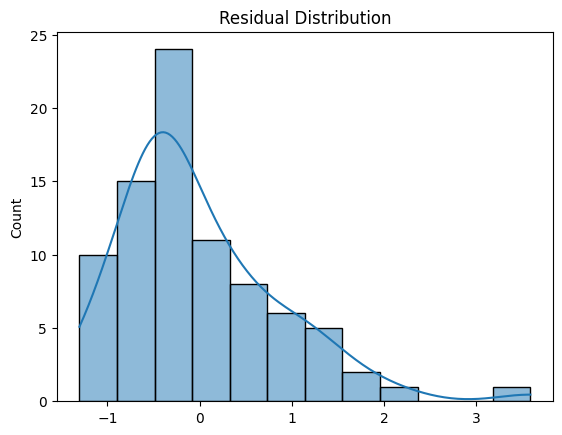

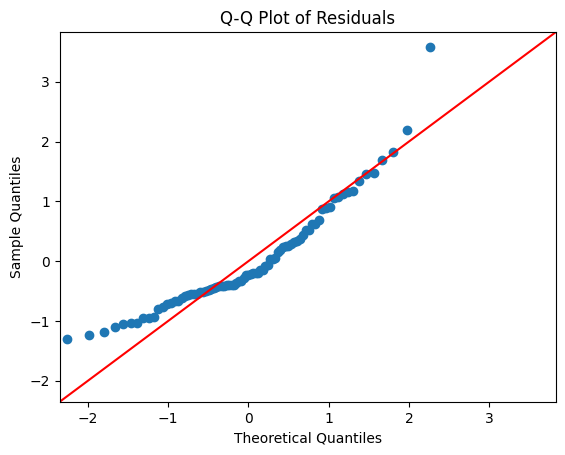

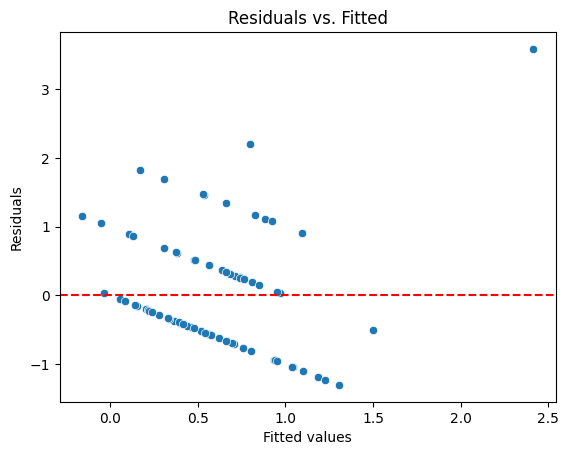


Best alpha chosen by LassoCV: 0.31623
Number of nonzero coefficients: 1 out of 12

Lasso coefficients:
ideas_second_half: -0.0000
net_positive_conflict_score: 0.0000
num_assign_task: 0.0000
num_confirm_decision: 0.0000
num_encourage_participation: 0.0000
num_express_agreement: -0.0000
num_express_enthusiasm: 0.0000
num_express_frustration: 0.0000
num_express_humor: 0.0000
num_propose_decision: -0.0000
num_resolve_conflict: -0.0000
total_speaking_length: 0.0922


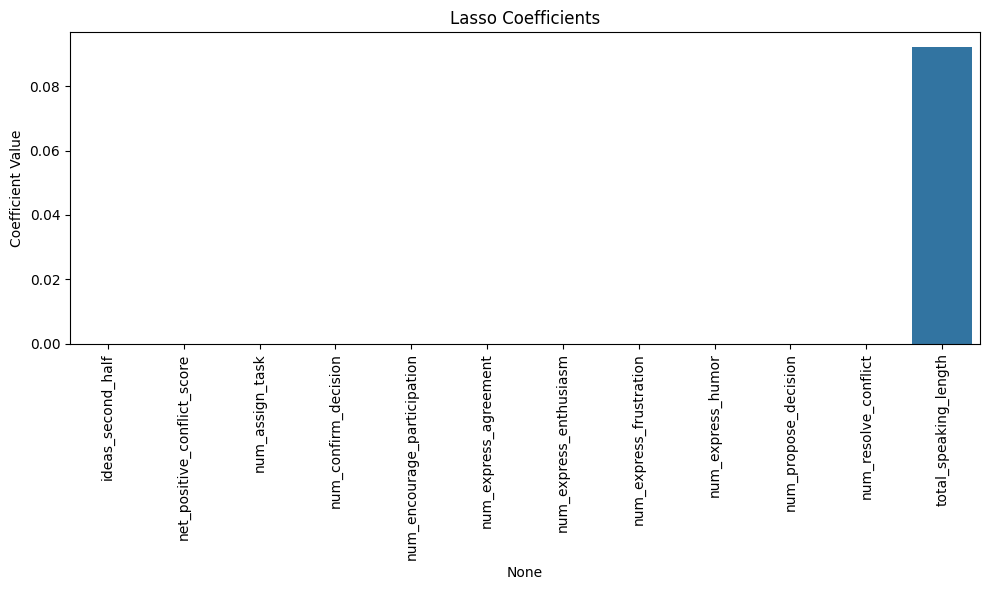

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# --- Residual plots from original OLS model (if available) ---
if 'model' in locals():
    residuals = model.resid
    fitted = model.fittedvalues

    sns.histplot(residuals, kde=True)
    plt.title("Residual Distribution")
    plt.show()

    sm.qqplot(residuals, line='45')
    plt.title("Q-Q Plot of Residuals")
    plt.show()

    sns.scatterplot(x=fitted, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.title("Residuals vs. Fitted")
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.show()

# --- Add 'total_speaking_length' as duration proxy if not already in predictors ---
if "total_speaking_length" not in final_predictors:
    final_predictors.append("total_speaking_length")

# --- Define X and y ---
X = df_model_clean[final_predictors]
y = df_model_clean["num_funded_teams"]

# --- Lasso Regression ---
lasso_alphas = np.logspace(-4, 0.5, 100)
lasso = make_pipeline(StandardScaler(), LassoCV(cv=5, alphas=lasso_alphas, random_state=42))
lasso.fit(X, y)

best_alpha = lasso.named_steps["lassocv"].alpha_
coefs = lasso.named_steps["lassocv"].coef_
nonzero = np.count_nonzero(coefs)

print(f"\nBest alpha chosen by LassoCV: {best_alpha:.5f}")
print(f"Number of nonzero coefficients: {nonzero} out of {len(coefs)}\n")

print("Lasso coefficients:")
for name, coef in zip(X.columns, coefs):
    print(f"{name}: {coef:.4f}")

# --- Coefficient Plot or fallback ---
if nonzero > 0:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=X.columns, y=coefs)
    plt.xticks(rotation=90)
    plt.title("Lasso Coefficients")
    plt.ylabel("Coefficient Value")
    plt.tight_layout()
    plt.show()
else:
    print("\nAll coefficients are zero — Lasso regularized all features out. Trying Ridge and ElasticNet...\n")

    # --- Ridge Regression ---
    ridge_alphas = np.logspace(-4, 3, 100)
    ridge = make_pipeline(StandardScaler(), RidgeCV(alphas=ridge_alphas, cv=5))
    ridge.fit(X, y)
    ridge_coefs = ridge.named_steps["ridgecv"].coef_
    print(f"Ridge: Best alpha = {ridge.named_steps['ridgecv'].alpha_:.5f}")
    print("Ridge coefficients:")
    for name, coef in zip(X.columns, ridge_coefs):
        print(f"{name}: {coef:.4f}")

    # --- ElasticNet Regression ---
    enet = make_pipeline(
        StandardScaler(),
        ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], alphas=np.logspace(-4, 1, 100), cv=5, random_state=42)
    )
    enet.fit(X, y)
    enet_coefs = enet.named_steps["elasticnetcv"].coef_

    print(f"\nElasticNet: Best alpha = {enet.named_steps['elasticnetcv'].alpha_:.5f}, l1_ratio = {enet.named_steps['elasticnetcv'].l1_ratio_}")
    print("ElasticNet coefficients:")
    for name, coef in zip(X.columns, enet_coefs):
        print(f"{name}: {coef:.4f}")

    # --- Plot Ridge vs ElasticNet ---
    width = 0.35
    x = np.arange(len(X.columns))
    plt.figure(figsize=(12, 6))
    plt.bar(x - width/2, ridge_coefs, width, label='Ridge')
    plt.bar(x + width/2, enet_coefs, width, label='ElasticNet')
    plt.xticks(ticks=x, labels=X.columns, rotation=90)
    plt.axhline(0, color='black', linewidth=0.8)
    plt.ylabel("Coefficient Value")
    plt.title("Ridge vs. ElasticNet Coefficients")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [40]:
print(utterances_df.columns)




NameError: name 'utterances_df' is not defined

## Analysis Summary:

### Question 1: 

**Do you think regressions need to control for the length of the meetings? Since some are shorter (60 minutes) and a few are almost 90 minutes long?**

**Answer:** Yes - by Lasso Regression, the following occurs:

#### Methods Used:

`total_speaking_length` (coefficient: ~0.092) was set as control variable (meeting duration) with behavioral features. This was the only nonzero coefficient. Meaning once we control how long people talked, most behavioral variables no longer add predicitive value.
- In greater context: longer meetings leads to more behavioral actions (e.g. expressions, decisions). Controlling length allows to isolate behavioral signal.

### Question 2:

**Controlling the number of people in the meeting. Does this matter?**

**Answer:** Not yet solved

## STUFF TO DO (later sections):

- participant's introductions / qualifications.



Could i get num participants from the json files from the quotes?

